In [1]:
# EXPERIMENTAL
# Work in progress (do not use)

# find TC genesis from models based on work similar to FSU's methodology

# only focused on 1. so far:
# [1] https://journals.ametsoc.org/view/journals/wefo/28/6/waf-d-13-00008_1.xml
# [2] https://journals.ametsoc.org/view/journals/wefo/31/3/waf-d-15-0157_1.xml?tab_body=fulltext-display
# [3] https://journals.ametsoc.org/view/journals/wefo/32/1/waf-d-16-0072_1.xml

# units are metric, but scale may be mixed between internal representations of data, thresholds, and printouts

# partial TODO
#    extend/generalize to other models (NAV, GFS, ECM, CMC, UKMET need comparison to txt files)
#        fixed sign for RVMAX
#        need case example for SH (Lola?)
#        check output
#    get max 10m speed if available
#        87:10 metre U wind component:m s**-1 (instant):regular_ll:heightAboveGround:level 10 m:fcst time 96 hrs:from 202310190600
#        88:10 metre V wind component:m s**-1 (instant):regular_ll:heightAboveGround:level 10 m:fcst time 96 hrs:from 202310190600
#    save TC output to JSON
#    extend to handle multiple timesteps/bufrs
#        individually a single criteria being met is a disturbance,
#             start of 24 continuous hours of meeting criteriais a tc
#    automatically download model files (UKMET seems infeasible as it costs much money)

# thresholds for disturbances (reversed from text output from FSU)
disturbance_thresholds_path = 'disturbance_thresholds.json'

# shape file for placing lat,lon in basins which we are classifying
# each has an attribute called 'basin_name', with CPAC & EPAC combined as EPAC
# basins are NATL, EPAC, WPAC, IO, SH
shape_file = 'shapes/basins.shp'

# for debugging MSLP isobars (depth first search)
debug_isobar_images = False

# save vorticity calculations
debug_save_vorticity = False

In [2]:
# use cgroup (cgroup-tools) to set memory limit as percentage of memory
# add 3 lines to sudoers (use * in place of params), make sure to escape colons

import os
import subprocess
percent_memory_limit = 20
pid = os.getpid()

total_memory = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
memory_limit = int(total_memory * percent_memory_limit / 100)
cg_cmd = "sudo /usr/bin/cgcreate -g memory:mygroup"
subprocess.run(cg_cmd, shell=True)
move_notebook_to_cg_cmd = f"sudo /usr/bin/cgclassify -g memory:mygroup {pid}"
subprocess.run(move_notebook_to_cg_cmd, shell = True)
set_memory_limit_cmd = f"sudo /usr/bin/cgset -r memory.limit_in_bytes={memory_limit} memory:mygroup"
subprocess.run(set_memory_limit_cmd, shell = True)

CompletedProcess(args='sudo /usr/bin/cgset -r memory.limit_in_bytes=3337620684 memory:mygroup', returncode=0)

In [3]:
import json
import pygrib
import re
import math
from metpy.units import units
import metpy.constants as mpconst
import metpy.calc as mpcalc
import numpy as np
import pyproj
import geopandas as gpd
from shapely.geometry import Point

import traceback
import sys
import copy
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline

# may need to modify lzma.py in python folder to get this to work (pip install backports-lzma)
# this is for metpy
try:
    import lzma
except ImportError:
    import backports.lzma as lzma

gdf = gpd.read_file(shape_file)

disturbance_criteria_names_map = {
    'WS': 'vmax925',
    'THKN': 'gp250_850_thickness',
    'RV': 'rv850max'
}

# shape file attribute names to threshold names
shape_basin_names_to_threshold_names_map = {
    'NATL': 'AL',
    'WPAC': 'WP',
    'IO': 'IO',
    'SH': 'SH',
    'EPAC': 'EP'
}

with open(disturbance_thresholds_path, 'r') as f:
    disturbance_thresholds = json.loads(f.read())

In [4]:
def create_image(array, title, rv_to_sign = True):
    plt.figure(figsize=(8, 8))
    cmap = plt.cm.RdBu

    if array.dtype == bool:
        # Convert boolean values to 1.0 (True) and -1.0 (False)
        image = np.where(array, -1.0, 1.0)
    else:
        if rv_to_sign:
            # Map float values to 1.0 (>=0) and -1.0 (<0)
            image = np.where(array >= 0, 1.0, -1.0)
        else:
            image = array
            
    plt.imshow(image, cmap=cmap, interpolation='none')
    plt.title(title)

    for i in range(array.shape[0] + 1):
        plt.axhline(i - 0.5, color='black', lw=0.5)
        plt.axvline(i - 0.5, color='black', lw=0.5)

    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()

def list_available_parameters(grib_file):
    try:
        # Open the GRIB file
        grbs = pygrib.open(grib_file)

        # Initialize a list to store parameter information
        parameter_info = []

        # Iterate through the GRIB messages and extract parameter information
        for grb in grbs:
            parameter_name = grb.name
            parameter_unit = grb.units
            level_type = grb.levelType
            level = grb.level
            print(grb)
            parameter_info.append({
                "Parameter Name": parameter_name,
                "Unit": parameter_unit,
                "Level Type": level_type,
                "Level": level
            })

        # Close the GRIB file
        grbs.close()

        # Print the information for parameters
        for info in parameter_info:
            print("Parameter Name:", info["Parameter Name"])
            print("Unit:", info["Unit"])
            print("Level Type:", info["Level Type"])
            print("Level:", info["Level"])
            print("\n")

    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc(limit=None, file=None, chain=True)

def convert_to_signed_lon(lon):
    # Convert longitudes from 0-360 range to -180 to +180 range
    return (lon + 180) % 360 - 180

# this is in a number of cells radius from the center (so a neighborhood size of 1 would be 3x3)
def calculate_neighborhood_size(degree_radius, grid_resolution):
    # Calculate the radius in grid points
    radius_in_grid_points = int(degree_radius / grid_resolution)
    return radius_in_grid_points

def array_indices_to_lat_lon(x, y, lats, lons):
    lat = lats[x, y]
    lon = lons[x, y]
    signed_lon = convert_to_signed_lon(lon)
    return lat, signed_lon

# print candidates
def print_candidates(mslp_minima_list, lats = None, lons = None, meet_all_disturbance_thresholds = False):
    n = 0
    for candidate in mslp_minima_list:
        if meet_all_disturbance_thresholds:
            if not candidate['criteria']['all']:
                continue

        basin_str = ""
        if 'basin' in candidate:
            basin = candidate['basin']
            basin_str += f'{basin} Basin, '
        
        n += 1
        mslp_value = candidate["mslp_value"]
        
        if lats is not None and lons is not None:
            x = candidate["x_value"]
            y = candidate["y_value"]
            lat, lon = array_indices_to_lat_lon(x, y, lats, lons)
        else:
            lat = candidate['lat']
            lon = candidate['lon']

        formatted_mslp = f"{mslp_value:.1f}".rjust(6, ' ')
        rv_str = ""
        if 'rv850max'in candidate:
            rv_str = ", 850 RV MAX (*10^-5 1/s): "
            rv_value = candidate['rv850max'] * np.power(10.0,5)
            formatted_rv = f"{rv_value:2.2f}".rjust(5, ' ')
            rv_str += formatted_rv
        
        thickness_str = ""
        if 'gp250_850_thickness' in candidate:
            thickness_str = ", 250-850 hPa Thickness (m): "
            thickness_value = candidate['gp250_850_thickness']
            formatted_thickness = f"{thickness_value:2.2f}".rjust(6, ' ')
            thickness_str += formatted_thickness
        
        vmax_str = ""
        if 'vmax925' in candidate:
            vmax_str = ", 925 hPa WS MAX (m/s): "
            vmax_value = candidate['vmax925']
            formatted_vmax = f"{vmax_value:3.2f}".rjust(6, ' ')
            vmax_str += formatted_vmax
        
        print(f"#{n: >2}, {basin_str}Latitude (deg:): {lat: >6.1f}, Longitude (deg): {lon: >6.1f}, MSLP (hPa): {formatted_mslp}{rv_str}{thickness_str}{vmax_str}")

        if debug_isobar_images:
            create_image(candidate['neighborhood'], 'Neighborhood')
            create_image(candidate['visited'], 'Visited')
        
# this function is for checking find_mslp_minima_with_closed_isobars
def find_mslp_minima(mslp_data, minima_neighborhood_size=1):
    try:
        # Lists to store MSLP minima, latitudes, and longitudes
        candidates = []

        # Loop through each grid point
        for x in range(minima_neighborhood_size, mslp_data.shape[0] - minima_neighborhood_size):
            for y in range(minima_neighborhood_size, mslp_data.shape[1] - minima_neighborhood_size):
                mslp_value = mslp_data[x, y]  # MSLP value at the current point
                neighborhood = mslp_data[x - minima_neighborhood_size:x + minima_neighborhood_size + 1,
                                         y - minima_neighborhood_size:y + minima_neighborhood_size + 1]

                # Check if the MSLP value is the minimum within the neighborhood
                if mslp_value == neighborhood.min():
                    candidate = {
                        "mslp_value": mslp_value,
                        "x_value": x,
                        "y_value": y
                    }
                    candidates.append(candidate)


        return candidates
    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc(limit=None, file=None, chain=True)
        return [], [], []

# minima_neighborhood_size set to 1 finds the smallest area that could be called a relative minima in MSLP
# this can create many duplicates for the same cyclone
# [1] uses a 3 degree buffer over space and time to group together these disturbances as a cyclone:
# Quoting [1]; "a 3° buffer around the position at forecast hour 12. Note that the position at forecast hour 18 is on or within the 3° buffer. Thus, these two points are considered to be the same TC. A new buffer is then drawn around the location at forecast hour 18 (green box), and a search is done for any positions on or within the buffer at forecast hour 24. This process is repeated until no points are found on or within the buffer."
def find_mslp_minima_with_closed_isobars(mslp_data, grid_resolution, isobar_threshold=2.0, isobar_search_radius_degrees = 5, minima_neighborhood_size = 1):
    isobar_neighborhood_size = calculate_neighborhood_size(isobar_search_radius_degrees, grid_resolution)
    #print('isobar neighborsize', isobar_neighborhood_size)
    def dfs(x, y):
        nonlocal visited
        stack = [(x, y)]

        while stack:
            x, y = stack.pop()
            visited[x][y] = True

            # Check N, S, E, W neighbors
            neighbors = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]

            for nx, ny in neighbors:
                if 0 <= nx < isobar_neighborhood_size * 2 + 1 and 0 <= ny < isobar_neighborhood_size * 2 + 1:
                    if not visited[nx][ny]:
                        if nx == 0 or ny == 0 or nx == isobar_neighborhood_size * 2 or ny == isobar_neighborhood_size * 2:
                            return False
                        if neighborhood_modified[nx][ny] < 0:
                            stack.append((nx, ny))
        return True

    try:
        # List to store MSLP minima as dictionaries
        mslp_minima_list = []

        # Create a list of candidates for MSLP minima
        candidates = []

        # Loop through each grid point
        for x in range(mslp_data.shape[0]):
            for y in range(mslp_data.shape[1]):
                mslp_value = mslp_data[x, y]  # MSLP value at the current point
                
                x_min = x - minima_neighborhood_size
                x_max = x + minima_neighborhood_size + 1
                y_min = y - minima_neighborhood_size
                y_max = y + minima_neighborhood_size + 1

                in_bounds = ((x_min >= 0) and
                    (x_max <= mslp_data.shape[0]) and
                    (y_min >= 0) and
                    (y_max <= mslp_data.shape[1]))

                if in_bounds:
                    # the normal case (not edges of array)
                    neighborhood = mslp_data[x_min:x_max, y_min:y_max]
                else:
                    # handle indices at the boundaries
                    neighborhood = extract_2d_neighborhood(mslp_data, (x, y), minima_neighborhood_size)
                
                # Check if the MSLP value is the minimum within the neighborhood
                if mslp_value == neighborhood.min():
                    candidates.append((x, y, mslp_value))

        # Loop through the candidates to find isobars
        for x, y, minima_value in candidates:
            # Create a modified neighborhood for isobar calculation
            
            x_min = x - isobar_neighborhood_size
            x_max = x + isobar_neighborhood_size + 1
            y_min = y - isobar_neighborhood_size
            y_max = y + isobar_neighborhood_size + 1
            
            in_bounds = ((x_min >= 0) and
                (x_max <= mslp_data.shape[0]) and
                (y_min >= 0) and
                (y_max <= mslp_data.shape[1]))

            if in_bounds:
                # the normal case (not edges of array)
                neighborhood = mslp_data[x_min:x_max, y_min:y_max]
            else:
                # handle indices at the boundaries
                neighborhood = extract_2d_neighborhood(mslp_data, (x, y), isobar_neighborhood_size)

            neighborhood_modified = neighborhood - minima_value - isobar_threshold

            # Initialize visited array for DFS
            visited = np.zeros_like(neighborhood_modified, dtype=bool)

            # Flag to track if a closed path is found
            path_found = dfs(isobar_neighborhood_size, isobar_neighborhood_size)

            if path_found:
                # Store MSLP minima data as a dictionary
                if debug_isobar_images:
                    candidate = {
                        "mslp_value": minima_value,
                        "x_value": x,
                        "y_value": y,
                        "neighborhood": copy.deepcopy(neighborhood_modified),
                        "visited": copy.deepcopy(visited)
                    }
                else:
                    candidate = {
                        "mslp_value": minima_value,
                        "x_value": x,
                        "y_value": y
                    }
                mslp_minima_list.append(candidate)


        return mslp_minima_list

    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc(limit=None, file=None, chain=True)
        return []

# calculate vorticity (accounting for projection distortion) using metpy (uses finite differences method)
# returns vorticity using an ellipsoid based on WGS84
def calculate_vorticity(u_wind_850, v_wind_850, lats, lons):
    # Convert wind components to units
    u_wind_850_with_units = units.Quantity(u_wind_850, 'm/s')
    v_wind_850_with_units = units.Quantity(v_wind_850, 'm/s')

    # can't use WGS84, per https://www.github.com/deeplycloudy/7b8412094c7a249d19b771374f312750
    ##Calculate grid spacing distances (these will be the dx and dy values used for calculating vorticity)
    ellipsoid = pyproj.Geod(ellps="WGS84")
    dx, dy = mpcalc.lat_lon_grid_deltas(lons * units.degrees, lats * units.degrees, geod=ellipsoid)
    #print(dx.shape, dy.shape)
    #print("calculate_vorticity dx,dy:", dx,dy)
    # Calculate relative vorticity (use WGS84)
    vort_850 = np.array(mpcalc.vorticity(u_wind_850_with_units, v_wind_850_with_units, dx=dx, dy=dy))
    masked_vort_850 = np.ma.masked_invalid(vort_850)
    
    #dx, dy = mpcalc.lat_lon_grid_deltas(lons * units.degrees, lats * units.degrees)
    #print(dx.shape, dy.shape)
    
    #vor = np.array(mpcalc.vorticity(u_wind_850_with_units, v_wind_850_with_units, dx=dx, dy=dy))
    #vor_corrected = units.Quantity(vor, '1/s')  + u_wind_850_with_units / mpconst.earth_avg_radius * np.tan(np.deg2rad(lats[:, None]))
    
    #masked_vort_850 = np.ma.masked_invalid(np.array(vor_corrected))
    
    np.ma.set_fill_value(masked_vort_850, -9999.0)
    # return as a masked array (this will hide NaNs: needed for getting the correct max and saving the calculation)
    return masked_vort_850

# Function to find RV maximums in neighborhoods for a list of candidates
def find_rv_maximums_in_neighborhoods(mslp_minima_list, rv, grid_resolution, relative_vorticity_radius_degrees = 2):
    neighborhood_size = calculate_neighborhood_size(relative_vorticity_radius_degrees, grid_resolution)
    updated_mslp_minima_list = []

    for candidate in mslp_minima_list:
        x, y, _ = candidate["x_value"], candidate["y_value"], candidate["mslp_value"]

        # Extract the neighborhood for the current candidate
        x_min = x - neighborhood_size
        x_max = x + neighborhood_size + 1
        y_min = y - neighborhood_size
        y_max = y + neighborhood_size + 1

        in_bounds = ((x_min >= 0) and
            (x_max <= rv.shape[0]) and
            (y_min >= 0) and
            (y_max <= rv.shape[1]))

        if in_bounds:
            # the normal case (not edges of array)
            neighborhood = rv[x_min:x_max, y_min:y_max]
        else:
            # handle indices at the boundaries
            neighborhood = extract_2d_neighborhood(rv, (x, y), neighborhood_size)

        # Find the maximum RV value within the neighborhood
        # need to adjust by latitude (vorticity will be negative for southern hemisphere)
        lat = candidate["lat"]
        if lat < 0:
            rv_max = neighborhood.min()
        else:
            rv_max = neighborhood.max()

        # Update a copy of the candidate's dictionary with rv maximum value
        updated_candidate = copy.deepcopy(candidate)
        updated_candidate["rv850max"] = rv_max

        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list
    
# calculate relative max thickness for 250hPa - 850hPa for a list of candidates
def find_gp_250_850_max_thickness(mslp_minima_list, geopotential_250, geopotential_850, grid_resolution, degrees_radius=2):
    # Calculate the neighborhood size based on degrees_radius and grid_resolution
    neighborhood_size = calculate_neighborhood_size(degrees_radius, grid_resolution)

    updated_mslp_minima_list = []
    
    # Iterate over the list of candidates
    for candidate in mslp_minima_list:
        # Extract the x and y indices of the candidate
        x, y = candidate['x_value'], candidate['y_value']

        # Extract the neighborhoods for 250 hPa and 850 hPa
        x_min = x - neighborhood_size
        x_max = x + neighborhood_size + 1
        y_min = y - neighborhood_size
        y_max = y + neighborhood_size + 1

        in_bounds = ((x_min >= 0) and
            (x_max <= geopotential_250.shape[0]) and
            (y_min >= 0) and
            (y_max <= geopotential_250.shape[1]))

        if in_bounds:
            # the normal case (not edges of array)
            neighborhood_250 = geopotential_250[x_min:x_max, y_min:y_max]
            neighborhood_850 = geopotential_850[x_min:x_max, y_min:y_max]
        else:
            # handle indices at the boundaries
            neighborhood_250 = extract_2d_neighborhood(geopotential_250, (x, y), neighborhood_size)
            neighborhood_850 = extract_2d_neighborhood(geopotential_850, (x, y), neighborhood_size)

        # Calculate the 250–850-hPa thickness for each cell in the neighborhood
        thickness = neighborhood_250 - neighborhood_850

        # Find the maximum thickness value in the neighborhood
        max_thickness = thickness.max()

        # Update a copy of the candidate's dictionary with the maximum thickness value
        updated_candidate = copy.deepcopy(candidate)
        updated_candidate['gp250_850_thickness'] = max_thickness
        
        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list

# find max wind at 925 hPa for a list of candidates
def find_max_wind_925(mslp_minima_list, u_wind_925, v_wind_925, grid_resolution, degrees_radius=5):
    # Calculate the neighborhood size based on radius_degrees and grid_resolution for wind
    neighborhood_size = calculate_neighborhood_size(degrees_radius, grid_resolution)

    updated_mslp_minima_list = []

    # Iterate over the list of candidates
    for candidate in mslp_minima_list:
        # Extract the neighborhoods for u-wind and v-wind at 925 hPa

        # Extract the x and y indices of the candidate
        x = candidate['x_value']
        y = candidate['y_value']
        
        x_min = x - neighborhood_size
        x_max = x + neighborhood_size + 1
        y_min = y - neighborhood_size
        y_max = y + neighborhood_size + 1

        in_bounds = ((x_min >= 0) and
            (x_max <= u_wind_925.shape[0]) and
            (y_min >= 0) and
            (y_max <= u_wind_925.shape[1]))

        if in_bounds:
            # the normal case (not edges of array)
            neighborhood_u_wind = u_wind_925[x_min:x_max, y_min:y_max]
            neighborhood_v_wind = v_wind_925[x_min:x_max, y_min:y_max]
        else:
            # handle indices at the boundaries
            neighborhood_u_wind = extract_2d_neighborhood(u_wind_925, (x, y), neighborhood_size)
            neighborhood_v_wind = extract_2d_neighborhood(v_wind_925, (x, y), neighborhood_size)

        # Calculate wind speed in the neighborhood
        wind_speed = np.sqrt(neighborhood_u_wind ** 2 + neighborhood_v_wind ** 2)

        # Find the maximum wind speed value in the neighborhood
        max_wind_speed = wind_speed.max()

        # Update a copy of the candidate's dictionary with the maximum wind speed value
        updated_candidate = copy.deepcopy(candidate)
        updated_candidate['vmax925'] = max_wind_speed
        
        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list

# add basin name, and also removes candidates that aren't in one of the basins
# add lat,lon also
def add_basin_name(mslp_minima_list, lats, lons):
    updated_mslp_minima_list = []

    for candidate in mslp_minima_list:
        x = candidate["x_value"]
        y = candidate["y_value"]

        lat, lon = array_indices_to_lat_lon(x, y, lats, lons)
        basin_name = get_basin_name_from_lat_lon(lat, lon)
        
        # remove candidate if not in a basin we are considering
        if not basin_name:
            continue
        
        # Update a copy of the candidate's dictionary with rv maximum value
        updated_candidate = copy.deepcopy(candidate)
        updated_candidate['basin'] = basin_name
        updated_candidate['lat'] = lat
        updated_candidate['lon'] = lon
        
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list

# Function to calculate the booleans on disturbance thresholds are met or not for each criteria and for all
# Must calculate and update with the basin classification first
def calc_disturbance_threshold_booleans(mslp_minima_list, model_name):
    updated_mslp_minima_list = []

    for candidate in mslp_minima_list:
        # Update a copy of the candidate's dictionary with rv maximum value
        updated_candidate = copy.deepcopy(candidate)
        all_met = True
        
        basin_name = candidate["basin"]
        lat = candidate["lat"]
        
        for criteria_abbrev, criteria_value in disturbance_thresholds[model_name][basin_name].items():
            criteria_name = disturbance_criteria_names_map[criteria_abbrev]
            flip_sign = 1
            if criteria_name == 'rv850max':
                # thresholds in the JSON for RV are scaled by 10^5
                criteria_value *= pow(10, -5)
                if lat < 0:
                    flip_sign = -1
            criteria_bool = False
            # for rv max flip sign for southern hemisphere (for other criteria, no)
            if updated_candidate[criteria_name] * flip_sign >= criteria_value:
                criteria_bool = True
            if 'criteria' not in updated_candidate:
                updated_candidate['criteria'] = {}
            updated_candidate['criteria'][criteria_name] = criteria_bool
            all_met = (all_met and criteria_bool)

        updated_candidate['criteria']['all'] = all_met
        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list

# returns the basin name from lat, lon if in a basin that is covered by the thresholds, otherwise returns None
def get_basin_name_from_lat_lon(lat, lon):
    # Create a Point geometry for the latitude and longitude
    point = Point(lon, lat)

    # Check if the point is within any of the polygons
    result = gdf[gdf.geometry.covers(point)]
    if not result.empty:
        shape_basin_name = result['basin_name'].iloc[0]
        # this is used for thresholds so return the threshold name
        return shape_basin_names_to_threshold_names_map[shape_basin_name]
    else:
        return None

# use u_wind_850 grib as reference and modify message to store vorticity
def save_vorticity_to_grib(u_wind_850_grib_file_path = None, grib_dest_file_path = None, relative_vorticity = None):
    if u_wind_850_grib_file_path is None or grib_dest_file_path is None or relative_vorticity is None:
        return
    
    print("open wind")
    grbs = pygrib.open(u_wind_850_grib_file_path)
    modified_grbs = []
    # Define the updated attributes for relative vorticity
    new_param_id = 138
    new_short_name = 'vo'

    for grb in grbs:
        # Modify parameter information
        grb.shortName = new_short_name
        grb.paramId = new_param_id
        # Replace values
        print("replaced names/id. replacing values")
        # doesn't seem to handle masked -nan values properly (encoding error), so fill with -9999
        grb.values = relative_vorticity.filled()
        print("replaced values")
        modified_grbs.append(grb)

    print("open file for write")
    # Create a new GRIB file with modified data
    with open(grib_dest_file_path, 'wb') as output_file:
        for modified_grb in modified_grbs:
            print("write file")
            output_file.write(modified_grb.tostring())
    print("done save")

# filter out candidates not meeting criteria
def get_disturbance_candidates_from_split_gribs(grib_files, model_name):
    # grid_resolution in degrees. MSLP is converted hPa, rest are converted to metric. Relative vorticity (1/s) is not scaled as threshold (not * 10^5)
    time_start = time.time()
    grid_resolution, lats, lons, mslp, u_wind_925, v_wind_925, u_wind_850, v_wind_850, geopotential_250, geopotential_850, relative_vorticity_850, u_wind_850_grib_file_path = load_and_extract_split_grib_data(grib_files, model_name)
    time_end = time.time()
    print(f'load_and_extract_split_grib_data() time (seconds): {time_end - time_start:.1f}')
    
    # check if an error was caught
    if lats is None:
        return None
    
    time_start = time.time()
    mslp_minima_list_with_closed_isobars = find_mslp_minima_with_closed_isobars(mslp, grid_resolution['mslp'])
    time_end = time.time()
    print(f'find_mslp_minima_with_closed_isobars() time (seconds): {time_end - time_start:.1f}')
    
    # if vorticity is missing, calculate relative vorticity for the entire data set first
    if relative_vorticity_850 is None:
        time_start = time.time()
        # this may issue warnings for divide by 0 for vorticity calculations
        print("Calculating Relative vorticity for 850 hPa")
        rv_850 = calculate_vorticity(u_wind_850, v_wind_850, lats, lons)
        time_end = time.time()
        print(f'calculate_vorticity() time (seconds): {time_end - time_start:.1f}')
        print("Finished calculating vorticity")
        # save the vorticity calculated to grib?
        if debug_save_vorticity:
            grib_dir = os.path.dirname(u_wind_850_grib_file_path)
            grib_dest_file_path = os.path.join(grib_dir, 'calculated_relative_vorticity.grib')
            print("Save vorticity...")
            print(np.unique(rv_850.filled()))
            save_vorticity_to_grib(u_wind_850_grib_file_path = u_wind_850_grib_file_path, grib_dest_file_path = grib_dest_file_path, relative_vorticity = rv_850)
    else:
        rv_850 = relative_vorticity_850

    time_start = time.time()
    # get lat/lon and basin name (exclude ones not in a basin we cover)
    mslp_minima_list_in_basins = add_basin_name(mslp_minima_list_with_closed_isobars, lats, lons)
    time_end = time.time()
    print(f'add_basin_name() time (seconds): {time_end - time_start:.1f}')
        
    # calculate relative vorticity maximum for each candidate
    time_start = time.time()
    mslp_minima_list_in_basins = find_rv_maximums_in_neighborhoods(mslp_minima_list_in_basins, rv_850, grid_resolution['gh250'])
    time_end = time.time()
    print(f'find_rv_maximums_in_neighborhoods() time (seconds): {time_end - time_start:.1f}')
    
    time_start = time.time()
    # Find the maximum relative thickness (250 - 850 hPa) for each candidate
    mslp_minima_list_in_basins = find_gp_250_850_max_thickness(mslp_minima_list_in_basins, geopotential_250, geopotential_850, grid_resolution['gh250'])
    time_end = time.time()
    print(f'find_gp_250_850_max_thickness() time (seconds): {time_end - time_start:.1f}')

    time_start = time.time()
    # find the maximum 925 hPa wind speed
    mslp_minima_list_in_basins = find_max_wind_925(mslp_minima_list_in_basins, u_wind_925, v_wind_925, grid_resolution['uwind925'])
    time_end = time.time()
    print(f'find_max_wind_925() time (seconds): {time_end - time_start:.1f}')
    
    time_start = time.time()
    mslp_minima_list_with_disturbance_threshold_booleans = calc_disturbance_threshold_booleans(mslp_minima_list_in_basins, model_name)
    time_end = time.time()
    print(f'calc_disturbance_threshold_booleans() time (seconds): {time_end - time_start:.1f}')
    # print_candidates(mslp_minima_list_with_disturbance_threshold_booleans, lats, lons, meet_all_disturbance_thresholds = True)

    time_start = time.time()
    # exclude disturbances not meeting all criteria
    updated_mslp_minima_list = []
    # Iterate over the list of candidates
    for candidate in mslp_minima_list_with_disturbance_threshold_booleans:
        # exclude candidates not meeting all criteria
        if not candidate['criteria']['all']:
            #print("Failed candidate:")
            #print(json.dumps(candidate,indent=4))
            continue

        # Update a copy of the candidate's dictionary with LAT, LON
        updated_candidate = copy.deepcopy(candidate)
        
        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    time_end = time.time()
    print(f'Remove candidates not meeting all criteria, time (seconds): {time_end - time_start:.1f}')
    print('\n')
    return updated_mslp_minima_list

def load_and_extract_split_grib_data(grib_files, model_name):
    try:
        # Initialize variables for relevant parameters
        mslp = None
        u_wind_925 = None
        v_wind_925 = None
        u_wind_850 = None
        v_wind_850 = None
        geopotential_250 = None
        geopotential_850 = None
        relative_vorticity_850 = None
        
        mslp_units = None
        wind_925_units = None
        wind_850_units = None
        
        mslp_lats = None
        mslp_lons = None
        u_wind_925_lats = None
        u_wind_925_lons = None
        v_wind_925_lats = None
        v_wind_925_lons = None
        u_wind_850_lats = None
        u_wind_850_lons = None
        v_wind_850_lats = None
        v_wind_850_lons = None
        geopotential_250_lats = None
        geopotential_250_lons = None
        geopotential_850_lats = None
        geopotential_850_lons = None
        relative_vorticity_850_lats = None
        relative_vorticity_850_lons = None
        
        # only used for reference to optionally store calculated relative vorticity
        u_wind_850_grib_file_path = None
        
        grid_resolution = {}

        for grib_file in grib_files:
            # Open the GRIB file
            grbs = pygrib.open(grib_file)
            # Extract relevant parameters (modify the parameter names and levels accordingly)
            for grb in grbs:
                if grb.level == 0 and grb.name in ['Pressure reduced to MSL', 'Mean sea level pressure']:
                    mslp = grb.values
                    mslp_units = grb.units
                    mslp_lats, mslp_lons = grb.latlons()
                    grid_resolution['mslp'] = grb['iDirectionIncrementInDegrees']
                elif grb.name == 'U component of wind' and grb.level == 925:
                    u_wind_925 = grb.values
                    wind_925_units = grb.units
                    u_wind_925_lats, u_wind_925_lons = grb.latlons()
                    grid_resolution['uwind925'] = grb['iDirectionIncrementInDegrees']
                elif grb.name == 'V component of wind' and grb.level == 925:
                    v_wind_925 = grb.values
                    v_wind_925_lats, v_wind_925_lons = grb.latlons()
                    grid_resolution['vwind925'] = grb['iDirectionIncrementInDegrees']
                elif grb.name == 'U component of wind' and grb.level == 850:
                    u_wind_850 = grb.values
                    wind_850_units = grb.units
                    u_wind_850_lats, u_wind_850_lons = grb.latlons()
                    u_wind_850_grib_file_path = grib_file
                    grid_resolution['uwind850'] = grb['iDirectionIncrementInDegrees']
                elif grb.name == 'V component of wind' and grb.level == 850:
                    v_wind_850 = grb.values
                    v_wind_850_lats, v_wind_850_lons = grb.latlons()
                    grid_resolution['vwind850'] = grb['iDirectionIncrementInDegrees']
                elif grb.name == 'Geopotential Height' and grb.level == 250:
                    geopotential_250 = grb.values
                    geopotential_250_lats, geopotential_250_lons = grb.latlons()
                    grid_resolution['gh250'] = grb['iDirectionIncrementInDegrees']
                elif grb.name == 'Geopotential Height' and grb.level == 850:
                    geopotential_850 = grb.values
                    geopotential_850_lats, geopotential_850_lons = grb.latlons()
                    grid_resolution['gh850'] = grb['iDirectionIncrementInDegrees']
                elif grb.name == 'Vorticity (relative)' and grb.level == 850:
                    relative_vorticity_850 = grb.values
                    relative_vorticity_850_lats, relative_vorticity_850_lons = grb.latlons()
                    grid_resolution['rv850'] = grb['iDirectionIncrementInDegrees']

            # Close the GRIB file
            grbs.close()

        # Check if units are not in hPa and convert if necessary
        if mslp_units != "hPa":
            #print(f"Converting MSLP units from {mslp_units} to hPa")
            if mslp_units == "Pa":
                # Convert from Pa to hPa
                mslp *= 0.01
                mslp_units = "hPa"
            else:
                print("Warning: Units of MSLP are not in Pa or hPa. Please verify the units for accurate results.")

        # Check if units are not in m/s for 925 hPa wind components and convert if necessary
        if not (re.search(r"(m/s|m s\*\*-1)", wind_925_units)):
            print(f"Converting 925 hPa wind components units from {wind_925_units} to m/s")
            if re.search(r"knots|knot", wind_925_units, re.I):
                # Convert from knots to m/s (1 knot ≈ 0.514444 m/s)
                u_wind_925 *= 0.514444
                v_wind_925 *= 0.514444
                wind_925_units = "m/s"
            else:
                print("Warning: Units of 925 hPa wind components are not in knots, m/s, or m s**-1. Please verify the units for accurate results.")
                
        # Check if units are not in m/s for 925 hPa wind components and convert if necessary
        if wind_850_units and not (re.search(r"(m/s|m s\*\*-1)", wind_850_units)):
            print(f"Converting 850 hPa wind components units from {wind_850_units} to m/s")
            if re.search(r"knots|knot", wind_925_units, re.I):
                # Convert from knots to m/s (1 knot ≈ 0.514444 m/s)
                u_wind_850 *= 0.514444
                v_wind_850 *= 0.514444
                wind_850_units = "m/s"
            else:
                print("Warning: Units of 925 hPa wind components are not in knots, m/s, or m s**-1. Please verify the units for accurate results.")
        
        # make sure shapes are all the same
        shapes = [x.shape for x in
            [
                mslp_lats, mslp_lons,
                u_wind_925_lats, u_wind_925_lons,
                v_wind_925_lats, v_wind_925_lons,
                u_wind_850_lats, u_wind_850_lons,
                v_wind_850_lats, v_wind_850_lons,
                geopotential_250_lats, geopotential_250_lons,
                geopotential_850_lats, geopotential_850_lons,
                relative_vorticity_850_lats, relative_vorticity_850_lons

            ] if x is not None]

        # check to make sure all the same shape
        if len(set(shapes)) != 1:
            # lats and lons different shapes!
            print(f"Error: getting disturbance candidates: lat,lons different shapes for: {grib_files}")
            return None, None, None, None, None, None, None, None, None, None, None, None
        
        lats = mslp_lats
        lons = mslp_lons
        
        return grid_resolution, lats, lons, mslp, u_wind_925, v_wind_925, u_wind_850, v_wind_850, geopotential_250, geopotential_850, relative_vorticity_850, u_wind_850_grib_file_path
    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc(limit=None, file=None, chain=True)

def extract_1d_neighborhood(arr, center_index, neighborhood_size):
    num_elements = arr.shape[0]
    neighborhood = np.zeros(2 * neighborhood_size + 1, dtype=arr.dtype)

    for i in range(-neighborhood_size, neighborhood_size + 1):
        index = (center_index + i) % num_elements
        neighborhood[i + neighborhood_size] = arr[index]

    return neighborhood

def extract_2d_neighborhood(arr, center_indices, neighborhood_size):
    """
    Extract a 2D neighborhood around a center index in a 2D array.

    Parameters:
    - arr: The 2D input array.
    - center_indices: A tuple (center_x, center_y) specifying the center indices.
    - neighborhood_size: The size of the neighborhood (half on each side of the center).

    Returns:
    - neighborhood: The extracted 2D neighborhood.
    """
    center_x, center_y = center_indices
    x_indices = range(center_x - neighborhood_size, center_x + neighborhood_size + 1)

    # Initialize an empty 2D neighborhood
    neighborhood = np.empty((2 * neighborhood_size + 1, 2 * neighborhood_size + 1), dtype=arr.dtype)
    
    num_elements = arr.shape[0]
    # Extract the 1D neighborhoods for each row
    for i, x in enumerate(x_indices):
        index = x % num_elements
        neighborhood[i] = extract_1d_neighborhood(arr[index], center_y, neighborhood_size)
    
    return neighborhood

In [49]:
# Get the current time before executing the code
time_start = time.time()

grib_files = [
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_002500-000000geop_ht',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_008500-000000geop_ht',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_008500-000000rltv_vort',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_009250-000000wnd_ucmp',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_009250-000000wnd_vcmp',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0102_000000-000000pres_msl',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0105_000100-000000wnd_ucmp',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0105_000100-000000wnd_vcmp'
]

model_name = 'NAV'
candidates2 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates2)

# getting the time taken for executing the code in seconds
time_end = time.time()

# Printing the time taken for code execution
print(f'Time taken for code execution (seconds): {time_end - time_start:.1f}')


load_and_extract_split_grib_data() time (seconds): 0.7
find_mslp_minima_with_closed_isobars() time (seconds): 3.0
add_basin_name() time (seconds): 0.1
find_rv_maximums_in_neighborhoods() time (seconds): 0.0
find_gp_250_850_max_thickness() time (seconds): 0.0
find_max_wind_925() time (seconds): 0.0
calc_disturbance_threshold_booleans() time (seconds): 0.0
Remove candidates not meeting all criteria, time (seconds): 0.0


# 1, SH Basin, Latitude (deg:):  -12.5, Longitude (deg):  167.0, MSLP (hPa):  982.3, 850 RV MAX (*10^-5 1/s): -78.60, 250-850 hPa Thickness (m): 9664.76, 925 hPa WS MAX (m/s):  44.59
# 2, SH Basin, Latitude (deg:):  -12.5, Longitude (deg):  167.5, MSLP (hPa):  982.3, 850 RV MAX (*10^-5 1/s): -78.60, 250-850 hPa Thickness (m): 9664.76, 925 hPa WS MAX (m/s):  44.59
# 3, EP Basin, Latitude (deg:):   11.0, Longitude (deg):  -96.5, MSLP (hPa):  996.5, 850 RV MAX (*10^-5 1/s): 39.90, 250-850 hPa Thickness (m): 9592.20, 925 hPa WS MAX (m/s):  40.00
# 4, IO Basin, Latitude (deg:

In [50]:
# Get the current time before executing the code
time_start = time.time()

grib_files = [
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_hgt_250_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_hgt_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_prmsl_mean_sea_level.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_ugrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_ugrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_ugrd_925_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_vgrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_vgrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_vgrd_925_mb.grib2'
]

model_name = 'GFS'
candidates3 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates3)

# getting the time taken for executing the code in seconds
time_end = time.time()

# Printing the time taken for code execution
print(f'Time taken for code execution (seconds): {time_end - time_start:.1f}')


load_and_extract_split_grib_data() time (seconds): 4.7
find_mslp_minima_with_closed_isobars() time (seconds): 8.2
Calculating Relative vorticity for 850 hPa


/home/db/.local/lib/python3.9/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


calculate_vorticity() time (seconds): 2.1
Finished calculating vorticity
add_basin_name() time (seconds): 0.5
find_rv_maximums_in_neighborhoods() time (seconds): 0.0
find_gp_250_850_max_thickness() time (seconds): 0.0
find_max_wind_925() time (seconds): 0.0
calc_disturbance_threshold_booleans() time (seconds): 0.0
Remove candidates not meeting all criteria, time (seconds): 0.0


# 1, EP Basin, Latitude (deg:):   22.8, Longitude (deg): -111.8, MSLP (hPa): 1005.4, 850 RV MAX (*10^-5 1/s): 207.69, 250-850 hPa Thickness (m): 9777.45, 925 hPa WS MAX (m/s):  50.33
# 2, EP Basin, Latitude (deg:):   22.8, Longitude (deg): -111.0, MSLP (hPa): 1005.1, 850 RV MAX (*10^-5 1/s): 207.69, 250-850 hPa Thickness (m): 9777.45, 925 hPa WS MAX (m/s):  50.33
# 3, EP Basin, Latitude (deg:):   21.8, Longitude (deg): -112.0, MSLP (hPa): 1004.7, 850 RV MAX (*10^-5 1/s): 207.69, 250-850 hPa Thickness (m): 9777.45, 925 hPa WS MAX (m/s):  50.33
# 4, EP Basin, Latitude (deg:):   20.8, Longitude (deg): -110.0, MSLP

In [19]:
# Get the current time before executing the code
time_start = time.time()

grib_files = [
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_10u_sfc.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_10v_sfc.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_gh_250_pl.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_gh_850_pl.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_msl_sfc.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_u_850_pl.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_u_925_pl.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_v_850_pl.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_v_925_pl.grib2'
]

model_name = 'ECM'
candidates4 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates4)

# getting the time taken for executing the code in seconds
time_end = time.time()

# Printing the time taken for code execution
print(f'Time taken for code execution (seconds): {time_end - time_start:.1f}')


load_and_extract_split_grib_data() time (seconds): 2.3
find_mslp_minima_with_closed_isobars() time (seconds): 3.4
Calculating Relative vorticity for 850 hPa


/home/db/.local/lib/python3.9/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


calculate_vorticity() time (seconds): 0.8
Finished calculating vorticity
Save vorticity...
[-9.99900000e+03 -5.24105490e-04 -5.23649569e-04 ...  8.71107038e-04
  1.17187066e-03  1.24597120e-03]
open wind
replaced names/id. replacing values
replaced values
open file for write
write file
done save
find_rv_maximums_in_neighborhoods() time (seconds): 0.0
find_gp_250_850_max_thickness() time (seconds): 0.0
find_max_wind_925() time (seconds): 0.0
add_basin_name() time (seconds): 0.6
calc_disturbance_threshold_booleans() time (seconds): 0.0
Remove candidates not meeting all criteria, time (seconds): 0.0


# 1, WP Basin, Latitude (deg:):   21.2, Longitude (deg):  109.6, MSLP (hPa): 1006.4, 850 RV MAX (*10^-5 1/s): 51.43, 250-850 hPa Thickness (m): 9550.65, 925 hPa WS MAX (m/s):  26.36
# 2, EP Basin, Latitude (deg:):   18.0, Longitude (deg): -108.0, MSLP (hPa):  976.6, 850 RV MAX (*10^-5 1/s): 124.60, 250-850 hPa Thickness (m): 9684.65, 925 hPa WS MAX (m/s):  40.30
# 3, AL Basin, Latitude (deg:

In [16]:
# Get the current time before executing the code
time_start = time.time()

grib_files = [
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_HGT_ISBL_250_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_HGT_ISBL_850_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_PRMSL_MSL_0_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_UGRD_ISBL_850_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_UGRD_ISBL_925_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_UGRD_TGL_10_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_VGRD_ISBL_850_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_VGRD_ISBL_925_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_VGRD_TGL_10_latlon.15x.15_2023102100_P000.grib2'
]

model_name = 'CMC'
candidates5 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates5)

# getting the time taken for executing the code in seconds
time_end = time.time()

# Printing the time taken for code execution
print(f'Time taken for code execution (seconds): {time_end - time_start:.1f}')


load_and_extract_split_grib_data() time (seconds): 34.8
find_mslp_minima_with_closed_isobars() time (seconds): 82.1
Calculating Relative vorticity for 850 hPa
calculate_vorticity() time (seconds): 6.0
Finished calculating vorticity
Save vorticity...
[-9.99900000e+03 -1.15283250e-03 -1.04078253e-03 ...  1.50161219e-03
  1.51297464e-03  1.52064569e-03]
open wind
replaced names/id. replacing values
replaced values
open file for write
write file
done save
find_rv_maximums_in_neighborhoods() time (seconds): 0.0
find_gp_250_850_max_thickness() time (seconds): 0.0
find_max_wind_925() time (seconds): 0.1
add_basin_name() time (seconds): 0.4
calc_disturbance_threshold_booleans() time (seconds): 0.0
Remove candidates not meeting all criteria, time (seconds): 0.0


# 1, EP Basin, Latitude (deg:):    9.0, Longitude (deg):  -96.0, MSLP (hPa): 1006.8, 850 RV MAX (*10^-5 1/s): 32.28, 250-850 hPa Thickness (m): 9538.66, 925 hPa WS MAX (m/s):  16.86
# 2, IO Basin, Latitude (deg:):   10.1, Longitude (de

In [20]:
# Get the current time before executing the code
time_start = time.time()

grib_files = [
'/home/db/metview/JRPdata/ukmet2/agl_u-component-of-wind-surface-adjusted_10.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/agl_v-component-of-wind-surface-adjusted_10.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_geopotential-height_25000.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_geopotential-height_85000.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_u-component-of-wind_85000.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_u-component-of-wind_92500.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_v-component-of-wind_85000.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_v-component-of-wind_92500.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/meansea_pressure-reduced-to-msl_2023102512_72.grib'
]

model_name = 'UKM'
candidates6 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates6)

# getting the time taken for executing the code in seconds
time_end = time.time()

# Printing the time taken for code execution
print(f'\nTime taken for code execution (seconds): {time_end - time_start:.1f}')


load_and_extract_split_grib_data() time (seconds): 20.3
find_mslp_minima_with_closed_isobars() time (seconds): 92.5
Calculating Relative vorticity for 850 hPa
calculate_vorticity() time (seconds): 10.2
Finished calculating vorticity
Save vorticity...
[-0.00580176 -0.00544608 -0.00533996 ...  0.00539042  0.00540246
  0.00573199]
open wind
replaced names/id. replacing values
replaced values
open file for write
write file
done save
find_rv_maximums_in_neighborhoods() time (seconds): 0.0
find_gp_250_850_max_thickness() time (seconds): 0.0
find_max_wind_925() time (seconds): 0.0
add_basin_name() time (seconds): 0.4
calc_disturbance_threshold_booleans() time (seconds): 0.0
Remove candidates not meeting all criteria, time (seconds): 0.0


# 1, AL Basin, Latitude (deg:):   32.7, Longitude (deg):  -60.0, MSLP (hPa):  994.1, 850 RV MAX (*10^-5 1/s): 113.64, 250-850 hPa Thickness (m): 9550.71, 925 hPa WS MAX (m/s):  34.88

Time taken for code execution (seconds): 125.3


In [13]:
list_available_parameters('/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_008500-000000rltv_vort')

1:Vorticity (relative):s**-1 (instant):regular_ll:isobaricInhPa:level 850:fcst time 96 hrs:from 202310190600
Parameter Name: Vorticity (relative)
Unit: s**-1
Level Type: pl
Level: 850




In [21]:
### TEST FOR SH (Lola) (gfs.20231021)
# Get the current time before executing the code
time_start = time.time()

grib_files = [
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_hgt_250_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_hgt_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_prmsl_mean_sea_level.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_ugrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_ugrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_ugrd_925_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_vgrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_vgrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_vgrd_925_mb.grib2'
]

model_name = 'GFS'
candidates6 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates6)

# getting the time taken for executing the code in seconds
time_end = time.time()

# Printing the time taken for code execution
print(f'\nTime taken for code execution (seconds): {time_end - time_start:.1f}')


load_and_extract_split_grib_data() time (seconds): 4.2
find_mslp_minima_with_closed_isobars() time (seconds): 9.5
Calculating Relative vorticity for 850 hPa


/home/db/.local/lib/python3.9/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


calculate_vorticity() time (seconds): 2.1
Finished calculating vorticity
Save vorticity...
[-9.99900000e+03 -1.04610500e-03 -7.85686522e-04 ...  1.93740909e-03
  2.12822399e-03  2.22739272e-03]
open wind
replaced names/id. replacing values
replaced values
open file for write
write file
done save
find_rv_maximums_in_neighborhoods() time (seconds): 0.0
find_gp_250_850_max_thickness() time (seconds): 0.0
find_max_wind_925() time (seconds): 0.0
add_basin_name() time (seconds): 0.5
calc_disturbance_threshold_booleans() time (seconds): 0.0
Remove candidates not meeting all criteria, time (seconds): 0.0


# 1, EP Basin, Latitude (deg:):   21.2, Longitude (deg): -110.0, MSLP (hPa):  969.0, 850 RV MAX (*10^-5 1/s): 222.74, 250-850 hPa Thickness (m): 9778.91, 925 hPa WS MAX (m/s):  55.07
# 2, AL Basin, Latitude (deg:):   15.2, Longitude (deg):  -60.2, MSLP (hPa):  996.3, 850 RV MAX (*10^-5 1/s): 122.35, 250-850 hPa Thickness (m): 9594.64, 925 hPa WS MAX (m/s):  29.80
# 3, IO Basin, Latitude (deg

In [52]:
disturbance_thresholds

{'NAV': {'EP': {'WS': 15.96, 'RV': 12.61, 'THKN': 9498.6},
  'AL': {'WS': 17.4, 'RV': 13.88, 'THKN': 9454.4},
  'WP': {'WS': 17.8, 'RV': 14.0, 'THKN': 9545.5},
  'IO': {'WS': 16.9, 'RV': 13.3, 'THKN': 9525.8},
  'SH': {'WS': 17.8, 'RV': 14.1, 'THKN': 9538.3}},
 'CMC': {'EP': {'WS': 15.79, 'RV': 14.92, 'THKN': 9483.3},
  'AL': {'WS': 17.01, 'RV': 15.29, 'THKN': 9478.5},
  'WP': {'WS': 19.6, 'RV': 20.1, 'THKN': 9551.0},
  'IO': {'WS': 18.3, 'RV': 19.4, 'THKN': 9527.1},
  'SH': {'WS': 19.4, 'RV': 20.2, 'THKN': 9538.4}},
 'GFS': {'EP': {'WS': 13.74, 'RV': 12.7, 'THKN': 9480.2},
  'AL': {'WS': 16.07, 'RV': 13.87, 'THKN': 9471.1},
  'WP': {'WS': 18.6, 'RV': 24.8, 'THKN': 9540.0},
  'IO': {'WS': 16.6, 'RV': 23.21, 'THKN': 9522.3},
  'SH': {'WS': 19.0, 'RV': 26.8, 'THKN': 9532.6}},
 'UKM': {'EP': {'WS': 15.06, 'RV': 14.2, 'THKN': 9490.0},
  'AL': {'WS': 15.68, 'RV': 14.53, 'THKN': 9471.0},
  'WP': {'WS': 18.6, 'RV': 28.8, 'THKN': 9542.0},
  'IO': {'WS': 18.9, 'RV': 32.12, 'THKN': 9540.0},
  'S

In [ ]:
### TEST FOR SH (Lola) (gfs.20231021)
# Get the current time before executing the code
time_start = time.time()

grib_files = [
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_hgt_250_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_hgt_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_prmsl_mean_sea_level.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_ugrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_ugrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_ugrd_925_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_vgrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_vgrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_vgrd_925_mb.grib2'
]

model_name = 'GFS'
candidates6 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates6)

# getting the time taken for executing the code in seconds
time_end = time.time()

# Prin``````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````ting the time taken for code execution
print(f'\nTime taken for code execution (seconds): {time_end - time_start:.1f}')


load_and_extract_split_grib_data() time (seconds): 4.4
find_mslp_minima_with_closed_isobars() time (seconds): 8.1
Calculating Relative vorticity for 850 hPa


/home/db/.local/lib/python3.9/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


In [62]:
# not working for SH basin...

In [107]:
grbu_path = '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_ugrd_850_mb.grib2'
grbv_path ='/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_vgrd_850_mb.grib2'

grb = pygrib.open(grbu_path)[1]
lats,lons = grb.latlons()
u_wind_850 = grb.values
grb = pygrib.open(grbv_path)[1]
lats,lons = grb.latlons()
v_wind_850 = grb.values
res = grb['iDirectionIncrementInDegrees']
neighborhood_size = calculate_neighborhood_size(2, res)

In [5]:
import xarray as xr
grbu_path = '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_ugrd_850_mb.grib2'
grbv_path ='/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_vgrd_850_mb.grib2'

grb = pygrib.open(grbu_path)[1]
lats,lons = grb.latlons()
u_wind_850 = grb.values
grb = pygrib.open(grbv_path)[1]
lats,lons = grb.latlons()
v_wind_850 = grb.values
res = grb['iDirectionIncrementInDegrees']

xu_wind_850 = xr.open_dataset(grbu_path, engine="cfgrib",filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
xv_wind_850 = xr.open_dataset(grbv_path, engine="cfgrib",filter_by_keys={'typeOfLevel': 'isobaricInhPa'})

In [6]:
import metview as mv
ug = mv.read(grbu_path)
vg = mv.read(grbv_path)

In [7]:
xu = ug.to_dataset()
xv = vg.to_dataset()
#vort_fieldset = mv.vorticity(xu,xv,mode='felem')
vort_fieldset = mv.vorticity(xu,xv)

/home/db/.local/lib/python3.9/site-packages/cfgrib/xarray_to_grib.py:261: FutureWarning: GRIB write support is experimental, DO NOT RELY ON IT!
  warnings.warn("GRIB write support is experimental, DO NOT RELY ON IT!", FutureWarning)
/home/db/.local/lib/python3.9/site-packages/cfgrib/xarray_to_grib.py:261: FutureWarning: GRIB write support is experimental, DO NOT RELY ON IT!
  warnings.warn("GRIB write support is experimental, DO NOT RELY ON IT!", FutureWarning)


In [8]:
vort_850 = vort_fieldset.to_dataset()['vo'].to_masked_array()
masked_vort_850 = vort_850

In [111]:
masked_vort_850 = np.ma.masked_invalid(vort_850)


#print(dx.shape, dy.shape)

#vor =` mpcalc.vorticity(u_wind_850_with_units, v_wind_850_with_units, crs=lla)
print(type(vor))
#vor_corrected = vor + u_wind_850_with_units / mpconst.earth_avg_radius * np.tan(np.deg2rad(lats[:, None]))
#print(type(vor_corrected))
#vor_corrected = units.Quantity(vor, '1/s')  + u_wind_850_with_units / mpconst.earth_avg_radius * np.tan(np.deg2rad(lats[:, None]))

masked_vort_850 = np.ma.masked_invalid(np.array(masked_vort_850))
#masked_vort_850 = np.ma.masked_invalid(vor)

np.ma.set_fill_value(masked_vort_850, -9999.0)
# return as a masked array (this will hide NaNs: needed for getting the correct max and saving the calculation)

<class 'pint.Quantity'>


In [38]:
u_wind_850_with_units = units.Quantity(u_wind_850, 'm/s')
v_wind_850_with_units = units.Quantity(v_wind_850, 'm/s')

# can't use WGS84, per https://www.github.com/deeplycloudy/7b8412094c7a249d19b771374f312750
##Calculate grid spacing distances (these will be the dx and dy values used for calculating vorticity)
ellipsoid = pyproj.Geod(ellps="WGS84")
dx, dy = mpcalc.lat_lon_grid_deltas(lons * units.degrees, lats * units.degrees, geod=ellipsoid)
print(dx)
print(dy)
print(dx.max())
print(dx.min())
print(dy.max())
print(dy.min())

[[0.0 0.0 0.0 ... 0.0 0.0 0.0] [121.83874004882423 121.83874004882423 121.83874004882423 ...  121.83874004882423 121.83874004882423 121.83874004882423] [243.67511357708747 243.67511357708747 243.67511357708747 ...  243.67511357708747 243.67511357708747 243.67511357708747] ... [243.67511357708747 243.67511357708747 243.67511357708747 ...  243.67511357708747 243.67511357708747 243.67511357708747] [121.83874004882423 121.83874004882423 121.83874004882423 ...  121.83874004882423 121.83874004882423 121.83874004882423] [0.0 0.0 0.0 ... 0.0 0.0 0.0]] meter
[[-27923.493098349983 -27923.493098349983 -27923.493098349983 ...  -27923.493098349983 -27923.493098349983 -27923.493098349983] [-27923.48234992645 -27923.48234992645 -27923.48234992645 ...  -27923.48234992645 -27923.48234992645 -27923.48234992645] [-27923.46085391861 -27923.46085391861 -27923.46085391861 ...  -27923.46085391861 -27923.46085391861 -27923.46085391861] ... [-27923.46085391861 -27923.46085391861 -27923.46085391861 ...  -27923.

In [39]:
import pyproj as proj4
def get_proj():
    # Define a WGS84 earth
    earth_major, earth_minor =  6378137.0, 6356752.3142
    
    # Spherical earth
#     earth_major, earth_minor =  6378137.0, 6378137.0 #6356752.3142
    
    eqc = proj4.crs.CRS(proj='eqc', a=earth_major, b=earth_minor,
                        lat_0=0.0, lon_0=0.0)
    lla = proj4.crs.CRS(proj='latlong', a=earth_major, b=earth_minor)
    ecef = proj4.crs.CRS(proj='geocent', a=earth_major, b=earth_minor)

    return lla, ecef, eqc

In [40]:
grb.projparams

{'a': 6371229, 'b': 6371229, 'proj': 'longlat'}

In [45]:
x = int(4*(90-(-13.5)))
y = int(4*(0+(167.0)))

lla, ecef, eqc = get_proj()

u_wind_850_with_units = units.Quantity(u_wind_850, 'm/s')
v_wind_850_with_units = units.Quantity(v_wind_850, 'm/s')

#print(dx.shape, dy.shape)
#print("calculate_vorticity dx,dy:", dx,dy)
# Calculate relative vorticity (use WGS84)
#vort_850 = np.array(mpcalc.vorticity(u_wind_850_with_units, v_wind_850_with_units, dx=dx, dy=dy))
#dx, dy = mpcalc.lat_lon_grid_deltas(lons * units.degrees, lats * units.degrees, geod=ellipsoid)
lats = xu_wind_850.latitude
lons = xu_wind_850.longitude

dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
vort_850 = np.array(mpcalc.vorticity(xu_wind_850, xv_wind_850, dx=dx, dy=dy))
masked_vort_850 = np.ma.masked_invalid(vort_850)


#print(dx.shape, dy.shape)

#vor = mpcalc.vorticity(u_wind_850_with_units, v_wind_850_with_units, crs=lla)
print(type(vor))
#vor_corrected = vor + u_wind_850_with_units / mpconst.earth_avg_radius * np.tan(np.deg2rad(lats[:, None]))
#print(type(vor_corrected))
#vor_corrected = units.Quantity(vor, '1/s')  + u_wind_850_with_units / mpconst.earth_avg_radius * np.tan(np.deg2rad(lats[:, None]))

masked_vort_850 = np.ma.masked_invalid(np.array(vor_corrected))
#masked_vort_850 = np.ma.masked_invalid(vor)

np.ma.set_fill_value(masked_vort_850, -9999.0)
# return as a masked array (this will hide NaNs: needed for getting the correct max and saving the calculation)

ValueError: This function changed in 1.0--double check that the function is being called properly.
`vorticity` given arguments with incorrect units: `u` requires "[speed]" but given "none", `v` requires "[speed]" but given "none"
A xarray DataArray or numpy array `x` can be assigned a unit as follows:
    from metpy.units import units
    x = x * units("m/s")
For more information see the Units Tutorial: https://unidata.github.io/MetPy/latest/tutorials/unit_tutorial.html

In [ ]:
print(lats[x][y], lons[x][y])
print(lats[x+1][y], lons[x+1][y])

In [113]:
rv = masked_vort_850


array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [-3.04024434e-05, -3.04024434e-05,  3.81798134e-04, ...,
         -2.86040595e-05, -2.68052099e-05, -3.04024434e-05],
        [-3.51027120e-06, -3.51027120e-06, -5.30888792e-06, ...,
         -3.51027120e-06, -3.51027120e-06, -3.51027120e-06],
        ...,
        [ 7.72514613e-05,  7.72514613e-05, -1.30665372e-04, ...,
          7.72514613e-05,  7.72514613e-05,  7.72514613e-05],
        [-3.02691828e-04,  1.09540415e-04,  1.04144565e-04, ...,
          1.09540415e-04,  1.09540415e-04, -3.02691828e-04],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]],
      dtype=float32)

In [139]:
x,y
lats[x][y], lons[x][y]

(-13.5, 167.0)

In [9]:
x = int(4*(90-(-13.5)))
y = int(4*(0+(167.0)))

neighborhood_size = calculate_neighborhood_size(2, res)

#rv = masked_vort_850.filled()[0]
rv = vort_850
# Extract the neighborhood for the current candidate
x_min = x - neighborhood_size
x_max = x + neighborhood_size + 1
y_min = y - neighborhood_size
y_max = y + neighborhood_size + 1

in_bounds = ((x_min >= 0) and
    (x_max <= rv.shape[0]) and
    (y_min >= 0) and
    (y_max <= rv.shape[1]))

if in_bounds:
    # the normal case (not edges of array)
    neighborhood = rv[x_min:x_max, y_min:y_max]
else:
    # handle indices at the boundaries
    neighborhood = extract_2d_neighborhood(rv, (x, y), neighborhood_size)



In [10]:
# should be -168.75
neighborhood.min()

-0.0021307815

In [11]:
neighborhood.max()

0.00017040246

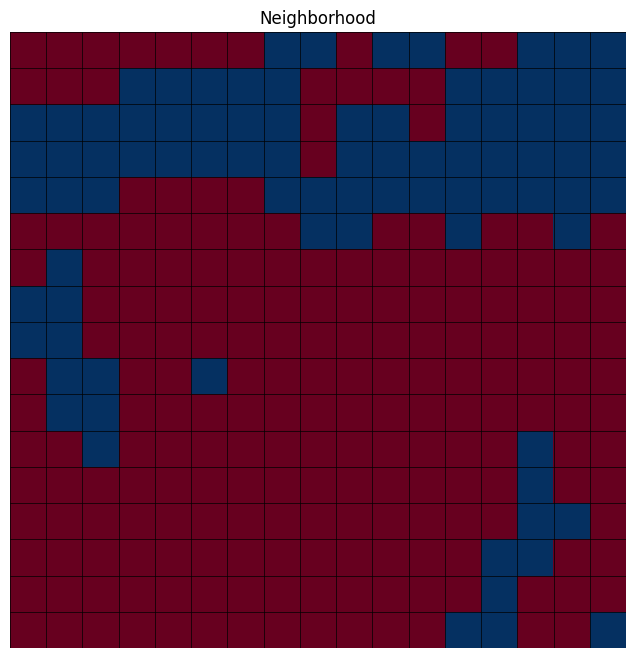

In [12]:
create_image(neighborhood, 'Neighborhood')

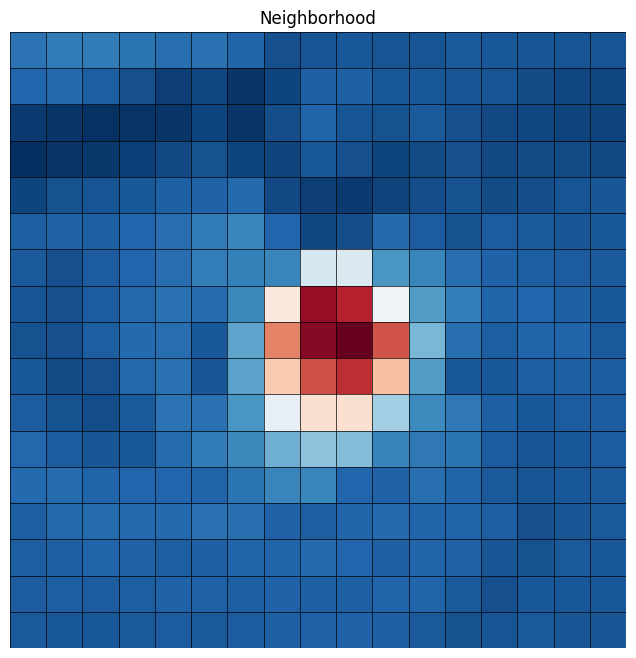

In [13]:
create_image(neighborhood, 'Neighborhood', rv_to_sign = False)

In [14]:
vort[0].shape

NameError: name 'vort' is not defined

In [146]:
masked_vort_850.filled()[0].shape

(721, 1440)

In [148]:
masked_vort_850.max()

0.0022252165

In [149]:
vort2 = vort

In [222]:
rv = vort_850[0]

In [237]:
neighborhood[8][8]

-0.0020233786

In [272]:
np.unravel_index(np.nanargmin(neighborhood), neighborhood.shape)

(8, 9)

In [273]:
rv[8][9]

6.8099005e-05

In [276]:
np.min(neighborhood)

-0.0021307815

In [268]:
np.abs(neighborhood)[15][0]

6.3873595e-05

In [275]:
neighborhood

masked_array(
  data=[[-9.401468560099602e-06, -5.8121513575315475e-06,
         -7.919734343886375e-06, -1.5460187569260597e-05,
         -1.9375933334231377e-05, -1.5934230759739876e-05,
         -2.5431392714381218e-05, -4.2163534089922905e-05,
         -4.761223681271076e-05, -5.322904326021671e-05,
         -4.033953882753849e-05, -1.0003102943301201e-05,
         2.1335436031222343e-05, 1.3839686289429665e-05,
         -1.6744481399655342e-05, -2.8242357075214386e-07,
         1.7022248357534409e-06],
        [-2.7222326025366783e-05, -2.738344483077526e-05,
         -2.4107983335852623e-05, -2.7834204956889153e-05,
         -5.1422277465462685e-05, -5.00993337482214e-05,
         -4.365644417703152e-05, -4.6194298192858696e-05,
         -4.480336792767048e-05, -4.4569140300154686e-05,
         -5.89985866099596e-05, -5.828798748552799e-05,
         -1.677754335105419e-05, 2.8867973014712334e-05,
         -5.77257014811039e-06, -7.326481863856316e-06,
         -1.5345867723226547